# Import Library

In [1]:
import numpy as np
import pandas as pd
import os
import time
import json
import tensorflow as tf
import random
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD  # Add this import
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
from IPython import display 

# Pernament Random

In [2]:
def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(42)

# Function

In [3]:
def load_data(csv_file):
    df_data  = pd.read_csv(csv_file)
    return df_data[["x1", "x2"]].values, df_data[["y"]].values.flatten()
# load_data

def load_dataset(csv_train = "./data/train.csv",
                 csv_valid = "./data/valid.csv",
                 csv_test  = "./data/test.csv"):
    # test
    x_test, y_test = load_data(csv_test)
    
    #train
    x_train, y_train = load_data(csv_train)
    
    #valid
    x_valid, y_valid = load_data(csv_valid)

    return x_train, y_train, x_valid, y_valid, x_test, y_test
# load_dataset

def visualize_dataset(x, y, color = "green", title = "Training Data\n", ax = None):
    if ax is None:
        plt.figure(figsize=(16, 6))
        ax = plt.subplot(1,2,1, projection='3d')
    # if

    surf = ax.scatter(x[:,0], x[:,1], y, c = color)
    ax.set_frame_on
    ax.set_xlabel('x1', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_ylabel('x2', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_zlabel("y", labelpad = 5, fontdict=dict(fontsize = 14))
    plt.legend(['Gaussian values'])
    plt.title(title, fontdict=dict(fontsize = 20))
# visualize_dataset

def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.title("Mean Squared Error")
    plt.plot(history.history["loss"], color="blue", label="train")
    plt.plot(history.history['val_loss'], color="orange", label='test')
# summarize_diagnostics

def visualize_logs(visualize_data, group_data, figsize = (10, 5), is_show = True, label_size = 12, title_size = 16, save_path = None):
    """
    visualize_data = df_logs[50:].to_dict(orient='list')
    group_data     = [{"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"], 
                       "title": "Error at Epoch {epoch}: {val_mean_squared_error:.4f}\n", 
                       "style": "min"},
                      {"x": "epoch", "y": ["loss", "val_loss"], 
                       "title": "Loss at Epoch {epoch}: {val_loss:.4f}\n", 
                       "style": "min"}]
    figsize        = (10, 5)
    visualize_logs(visualize_data, group_data, figsize)
    """
    import matplotlib.ticker as ticker
    import matplotlib.pyplot as plt, numpy as np
    
    fig = plt.figure(figsize=figsize)
    for idx, group in enumerate(group_data):
        x_axis_name, y_axis_names, title, style = group["x"], group["y"], group["title"], group["style"]
        x_values = visualize_data[x_axis_name]
        end_logs = dict([(x_axis_name, x_values[-1])])

        ax = plt.subplot(1, len(group_data), idx%len(group_data) + 1)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        for y_axis_name in y_axis_names:
            y_values = visualize_data[y_axis_name]
            if style is not None and style != "":
                y_values = []
                for i in range(len(visualize_data[y_axis_name])):
                    if style == "median":
                        y_values.append(np.median(visualize_data[y_axis_name][:i+1]))
                    elif style == "avg":
                        y_values.append(np.average(visualize_data[y_axis_name][:i+1]))
                    elif style == "max":
                        y_values.append(np.max(visualize_data[y_axis_name][:i+1]))
                    elif style == "min":
                        y_values.append(np.min(visualize_data[y_axis_name][:i+1]))
            # if
            end_logs.update(dict([(y_axis_name, y_values[-1])]))
            ax.plot(x_values, y_values)
        pass
        title = title.format(**end_logs)

        ax.set_xlabel(x_axis_name, fontsize = label_size)
        ax.legend(y_axis_names, loc='upper left', fontsize = label_size)
        ax.set_title(title, fontsize = title_size)
    # for
    
    if save_path is not None:
        save_dir = os.path.dirname(save_path)
        if save_dir != "" and os.path.exists(save_dir) == False: os.makedirs(save_dir)
        fig.savefig(save_path)
    # if
    
    if is_show == True: 
        plt.show()
        return None
    return fig
# visualize_logs

# Load Data

In [4]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="./data/train.csv", csv_valid="./data/valid.csv", csv_test="./data/test.csv")

# Model

In [5]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

def build_model(hidden_nodes=1):
    """
    Hàm xây dựng mô hình baseline với 1 hidden layer, đảm bảo khả năng thay đổi số lượng hidden nodes.

    Args:
        hidden_nodes (int): Số lượng hidden nodes trong hidden layer (mặc định là 1).

    Returns:
        model (Model): Mô hình Keras với 1 hidden layer, 2 input nodes, và 1 output node.
    """
    # Input layer với 2 input nodes
    inp = Input(shape=(2,), name='Input')
    
    # Hidden layer với số hidden nodes thay đổi
    x = Dense(units=hidden_nodes, activation='relu', name='HiddenLayer')(inp)
    
    # Output layer với 1 output node và hàm kích hoạt linear
    output_label = Dense(units=1, activation='linear', name='Output')(x)
    
    # Kết hợp thành mô hình
    model = Model(inputs=inp, outputs=output_label)
    
    # Hiển thị cấu trúc mô hình
    model.summary()
    
    return model


# Get Epoch

In [6]:
import json

# Load best_epoch from JSON file
with open('best_epoch.json', 'r') as f:
    data = json.load(f)
    best_epoch = data["best_epoch"]

print(f"Loaded best_epoch: {best_epoch}")


Loaded best_epoch: 156


# Get Sample Size

In [7]:
import json

# Load best_sample_size from JSON file
with open('best_sample_size.json', 'r') as f:
    data = json.load(f)
    best_sample_size = data["best_sample_size"]

print(f"Loaded best_sample_size: {best_sample_size}")


Loaded best_sample_size: 2800


# Get n Node

In [8]:
import json

# Load best_nhidden_node from JSON file
with open('best_nhidden_node.json', 'r') as f:
    data = json.load(f)
    best_nhidden_node = data["best_nhidden_node"]

print(f"Loaded best_nhidden_node: {best_nhidden_node}")


Loaded best_nhidden_node: 15


# Model

In [9]:
def build_model(hidden_layers=1, hidden_nodes=None):
    """
    Hàm xây dựng mô hình baseline với số lượng hidden layers và hidden nodes có thể thay đổi.
    Số lượng hidden nodes mặc định được lấy từ best_nhidden_node.

    Args:
        hidden_layers (int): Số lượng hidden layers.
        hidden_nodes (int): Số lượng hidden nodes trong mỗi hidden layer. Nếu không truyền, sử dụng best_nhidden_node.

    Returns:
        model (Model): Mô hình Keras với số hidden layers và nodes theo cấu hình.
    """
    # Nếu không chỉ định hidden_nodes, sử dụng giá trị từ best_nhidden_node
    if hidden_nodes is None:
        hidden_nodes = best_nhidden_node

    # Input layer với 2 input nodes
    inp = Input(shape=(2,), name='Input')
    x = inp  # Biến trung gian cho các hidden layers

    # Hidden layers: Thêm `hidden_layers` layers với `hidden_nodes` nodes mỗi layer
    for i in range(hidden_layers):
        x = Dense(units=hidden_nodes, activation='relu', name=f'HiddenLayer_{i+1}')(x)

    # Output layer với 1 output node và hàm kích hoạt linear
    output_label = Dense(units=1, activation='linear', name='Output')(x)

    # Kết hợp thành mô hình
    model = Model(inputs=inp, outputs=output_label)

    # Hiển thị cấu trúc mô hình
    model.summary()

    return model

# Train data

Train: x-shape = (2800, 2) y-shape = (2800,)
Valid: x-shape = (100, 2) y-shape = (100,)


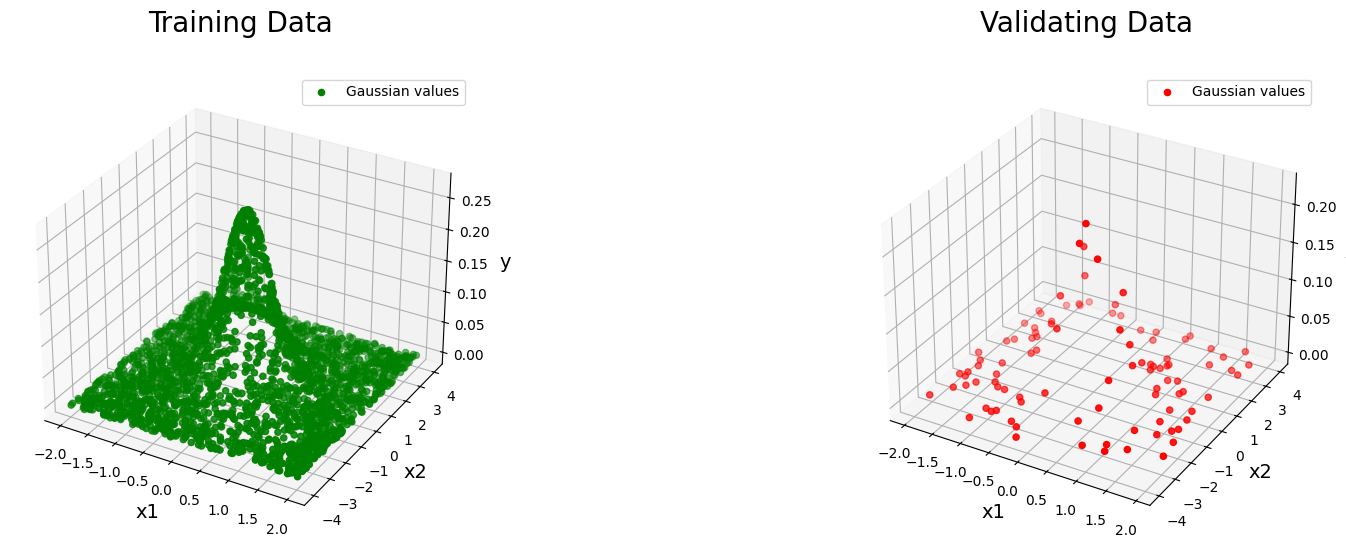

In [10]:
# Chuẩn bị dữ liệu huấn luyện và kiểm định
x_expLayer_train, y_expLayer_train = x_train[:best_sample_size], y_train[:best_sample_size]
x_expLayer_valid, y_expLayer_valid = x_valid, y_valid

print(f"Train: x-shape = {x_expLayer_train.shape} y-shape = {y_expLayer_train.shape}")
print(f"Valid: x-shape = {x_expLayer_valid.shape} y-shape = {y_expLayer_valid.shape}")

# Hiển thị dữ liệu huấn luyện và kiểm định
plt.figure(figsize=(20, 6))

ax1 = plt.subplot(1, 2, 1, projection='3d')
visualize_dataset(x_expLayer_train, y_expLayer_train, color="green", title="Training Data\n", ax=ax1)

ax2 = plt.subplot(1, 2, 2, projection='3d')
visualize_dataset(x_expLayer_valid, y_expLayer_valid, color="red", title="Validating Data\n", ax=ax2)


# Experiment Layers

## Model

In [11]:
expLayer = build_model()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer_1 (Dense)           │ (None, 15)             │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

## Training

In [12]:
def train_model_layers(train_id, x_local_train, y_local_train, x_local_valid, y_local_valid,
                       n_hidden_layers=1, nb_epochs=best_epoch):
    """
    Huấn luyện mô hình với số lớp ẩn cụ thể.
    """
    K.clear_session()
    # Sử dụng đúng tham số `hidden_layers` thay vì `n_hidden_layers`
    expLayer_model = build_model(hidden_layers=n_hidden_layers)

    # Cấu hình tối ưu hóa
    expLayer_model.compile(
        loss='mean_squared_error',
        optimizer=SGD(learning_rate=0.01),
        metrics=['mean_squared_error']
    )

    # CALLBACKS
    callbacks = []
    save_dir = f"./data/model/train_layers/{train_id}"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # ModelCheckpoint
    save_dir = f"./data/model/train_layers/{train_id}"
    if os.path.exists(save_dir)==False: os.makedirs(save_dir)
    template_name = "funcApxm_model_{epoch:02d}_{val_loss:.3f}_val_mse-{val_mean_squared_error:.3f}.keras"
    if os.path.exists(save_dir) == False: os.makedirs(save_dir)
    model_checkpoint = ModelCheckpoint(
        filepath=os.path.join(save_dir, template_name),
        monitor='val_loss',
        save_best_only=True,
        verbose=0,
        mode='auto',
        save_freq='epoch'
    )
    callbacks.append(model_checkpoint)

    # + Visualize logs
    review_logs = {}
    def custom_on_epoch_end(self, epoch, logs, **kwargs):   
        review_logs = kwargs["review_logs"]
        if epoch == 0:
            review_logs["epoch"] = [epoch]
            for key in logs.keys(): review_logs[key] = [logs[key]]
        # if
        review_logs["epoch"].append(epoch)
        for key in logs.keys(): review_logs[key].append(logs[key])

        visualize_data = review_logs
        group_view     = [{"x": "epoch", "y": ["loss", "val_loss"], 
                           "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n", 
                           "style": "median"}, 
                          {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"], 
                           "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n", 
                           "style": None}
                         ]
        fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False, 
                             save_path = os.path.join(f"./data/model/train_03/{train_id}", "logs.png"))
        plt.close()
        if epoch == 0:
            display.display(fig, display_id=f"logs_{train_id}")
        else:
            display.update_display(fig, display_id=f"logs_{train_id}")
        pass

    # custom_on_epoch_end
    custom_callbacks = LambdaCallback()
    custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
    callbacks.append(custom_callbacks) 
    # Huấn luyện mô hình
    batch_size = 128
    starting_time = time.time()
    history = expLayer_model.fit(
        x_local_train, y_local_train,
        validation_data=(x_local_valid, y_local_valid),
        batch_size=batch_size,
        epochs=nb_epochs,
        callbacks=callbacks,
        verbose=0
    )
    print('> training time is %.4f minutes' % ((time.time() - starting_time) / 60))
    return history


Train ID: 1, Hidden layers: 1



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer_1 (Dense)           │ (None, 15)             │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

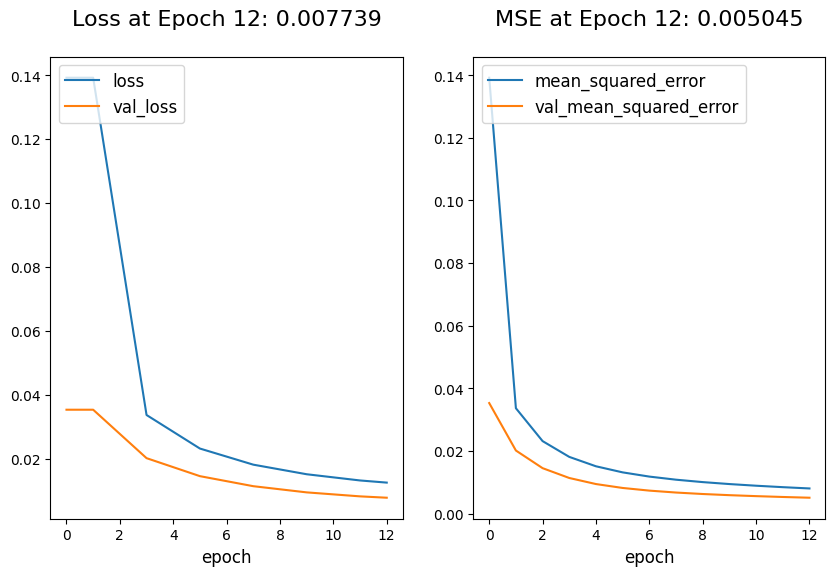

KeyboardInterrupt: 

In [13]:
# Huấn luyện với số lớp ẩn từ 1 đến 20
history = []
for i in range(1, 21):
    print(f"Train ID: {i}, Hidden layers: {i}")
    temp_history = train_model_layers(
        train_id=i,
        x_local_train=x_expLayer_train,
        y_local_train=y_expLayer_train,
        x_local_valid=x_expLayer_valid,
        y_local_valid=y_expLayer_valid,
        n_hidden_layers=i,  # Truyền tham số đúng
        nb_epochs=best_epoch)
    history.append(temp_history)


# Evaluating

Min Error at n_hidden_layers=7 with error = 0.00037458640872500837


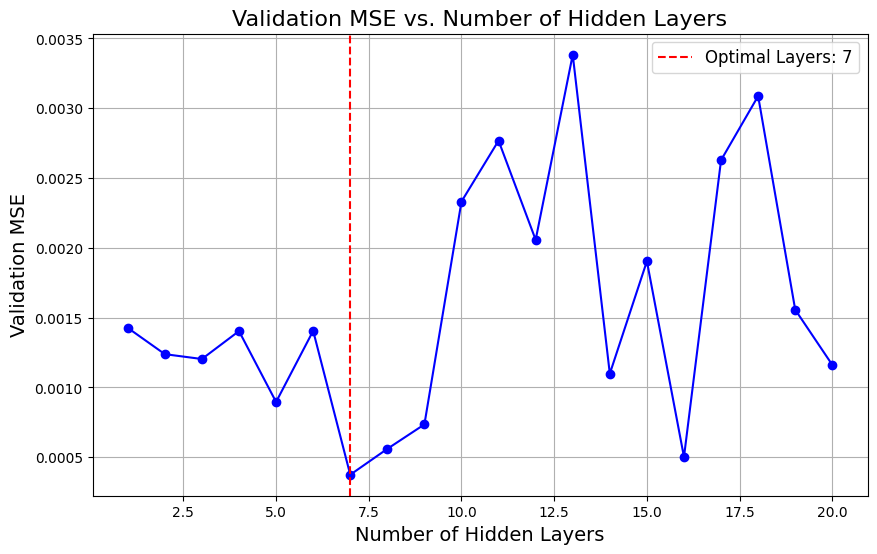

In [ ]:
# Tính MSE trên tập kiểm định
errors = []
for i, hist in enumerate(history):
    epoch_opt = np.argmin(hist.history["val_mean_squared_error"])
    error = hist.history["val_mean_squared_error"][epoch_opt]
    errors.append(error)

# Tìm số lớp ẩn tối ưu
hidden_layers = list(range(1, 21))
vt_min = np.argmin(errors)
print(f"Min Error at n_hidden_layers={hidden_layers[vt_min]} with error = {errors[vt_min]}")

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(hidden_layers, errors, marker='o', linestyle='-', color='b')
plt.axvline(hidden_layers[vt_min], color='r', linestyle='--', label=f"Optimal Layers: {hidden_layers[vt_min]}")
plt.title("Validation MSE vs. Number of Hidden Layers", fontsize=16)
plt.xlabel("Number of Hidden Layers", fontsize=14)
plt.ylabel("Validation MSE", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


In [ ]:
errors = []
for i in range(len(history)):
    epoch_opt = np.argmin(history[i].history["val_mean_squared_error"])
    error = history[i].history["val_mean_squared_error"][epoch_opt]
    errors.append(error)
# for
hiddens = list(range(1, 21, 1))

In [ ]:
vt_min = np.argmin(np.array(errors))
print(f"Min Error at n_hidden={hiddens[vt_min]} layers with error = {errors[vt_min]}")

Min Error at n_hidden=7 layers with error = 0.00037458640872500837


Text(0.5, 1.0, 'Performance against the # of training samples\n')

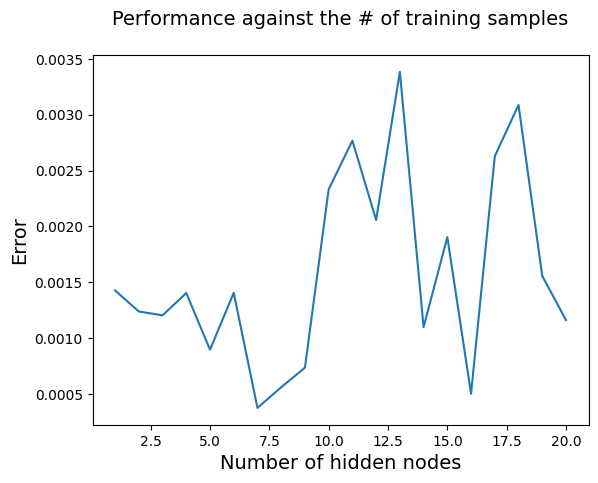

In [ ]:
plt.plot(hiddens, errors)
plt.xlabel("Number of hidden nodes", fontsize = 14)
plt.ylabel("Error", fontsize = 14)
plt.title("Performance against the # of training samples\n", fontsize = 14)